In [1]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code.git

Cloning into 'dlwpt-code'...
remote: Enumerating objects: 703, done.
remote: Total 703 (delta 0), reused 0 (delta 0), pack-reused 703
Receiving objects: 100% (703/703), 176.00 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Updating files: 100% (228/228), done.


In [2]:
import torch

In [4]:
t_c = [.5, 14., 15., 28., 11., 8., 3., -4., 6, 13, 21]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [5]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [ ]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [ ]:
delta = 0.1

loss_rate_of_change_w = (
    (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2*delta)
)

In [ ]:
lr = 1e-2
print(lr)

0.01


In [ ]:
w = w - lr * loss_rate_of_change_w

In [ ]:
loss_rate_of_change_b = (
    (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2*delta)
)
b = b - lr * loss_rate_of_change_b

In [ ]:
def training_loop(n_epochs, lr, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w,b = params
        t_p = model(t_u,w,b) # 순방향 전달
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c,t_p, w,b)   # 역방향 전달

        params = params - lr * grad

        print("Epoch %d, Loss %f" %(epoch, float(loss)))
    return params

In [ ]:
training_loop(
    n_epochs = 100,
    lr = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

In [ ]:
t_un = 0.1 * t_u

training_loop(
    n_epochs = 5000,
    lr = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c
)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

tensor([  5.3671, -17.3012])

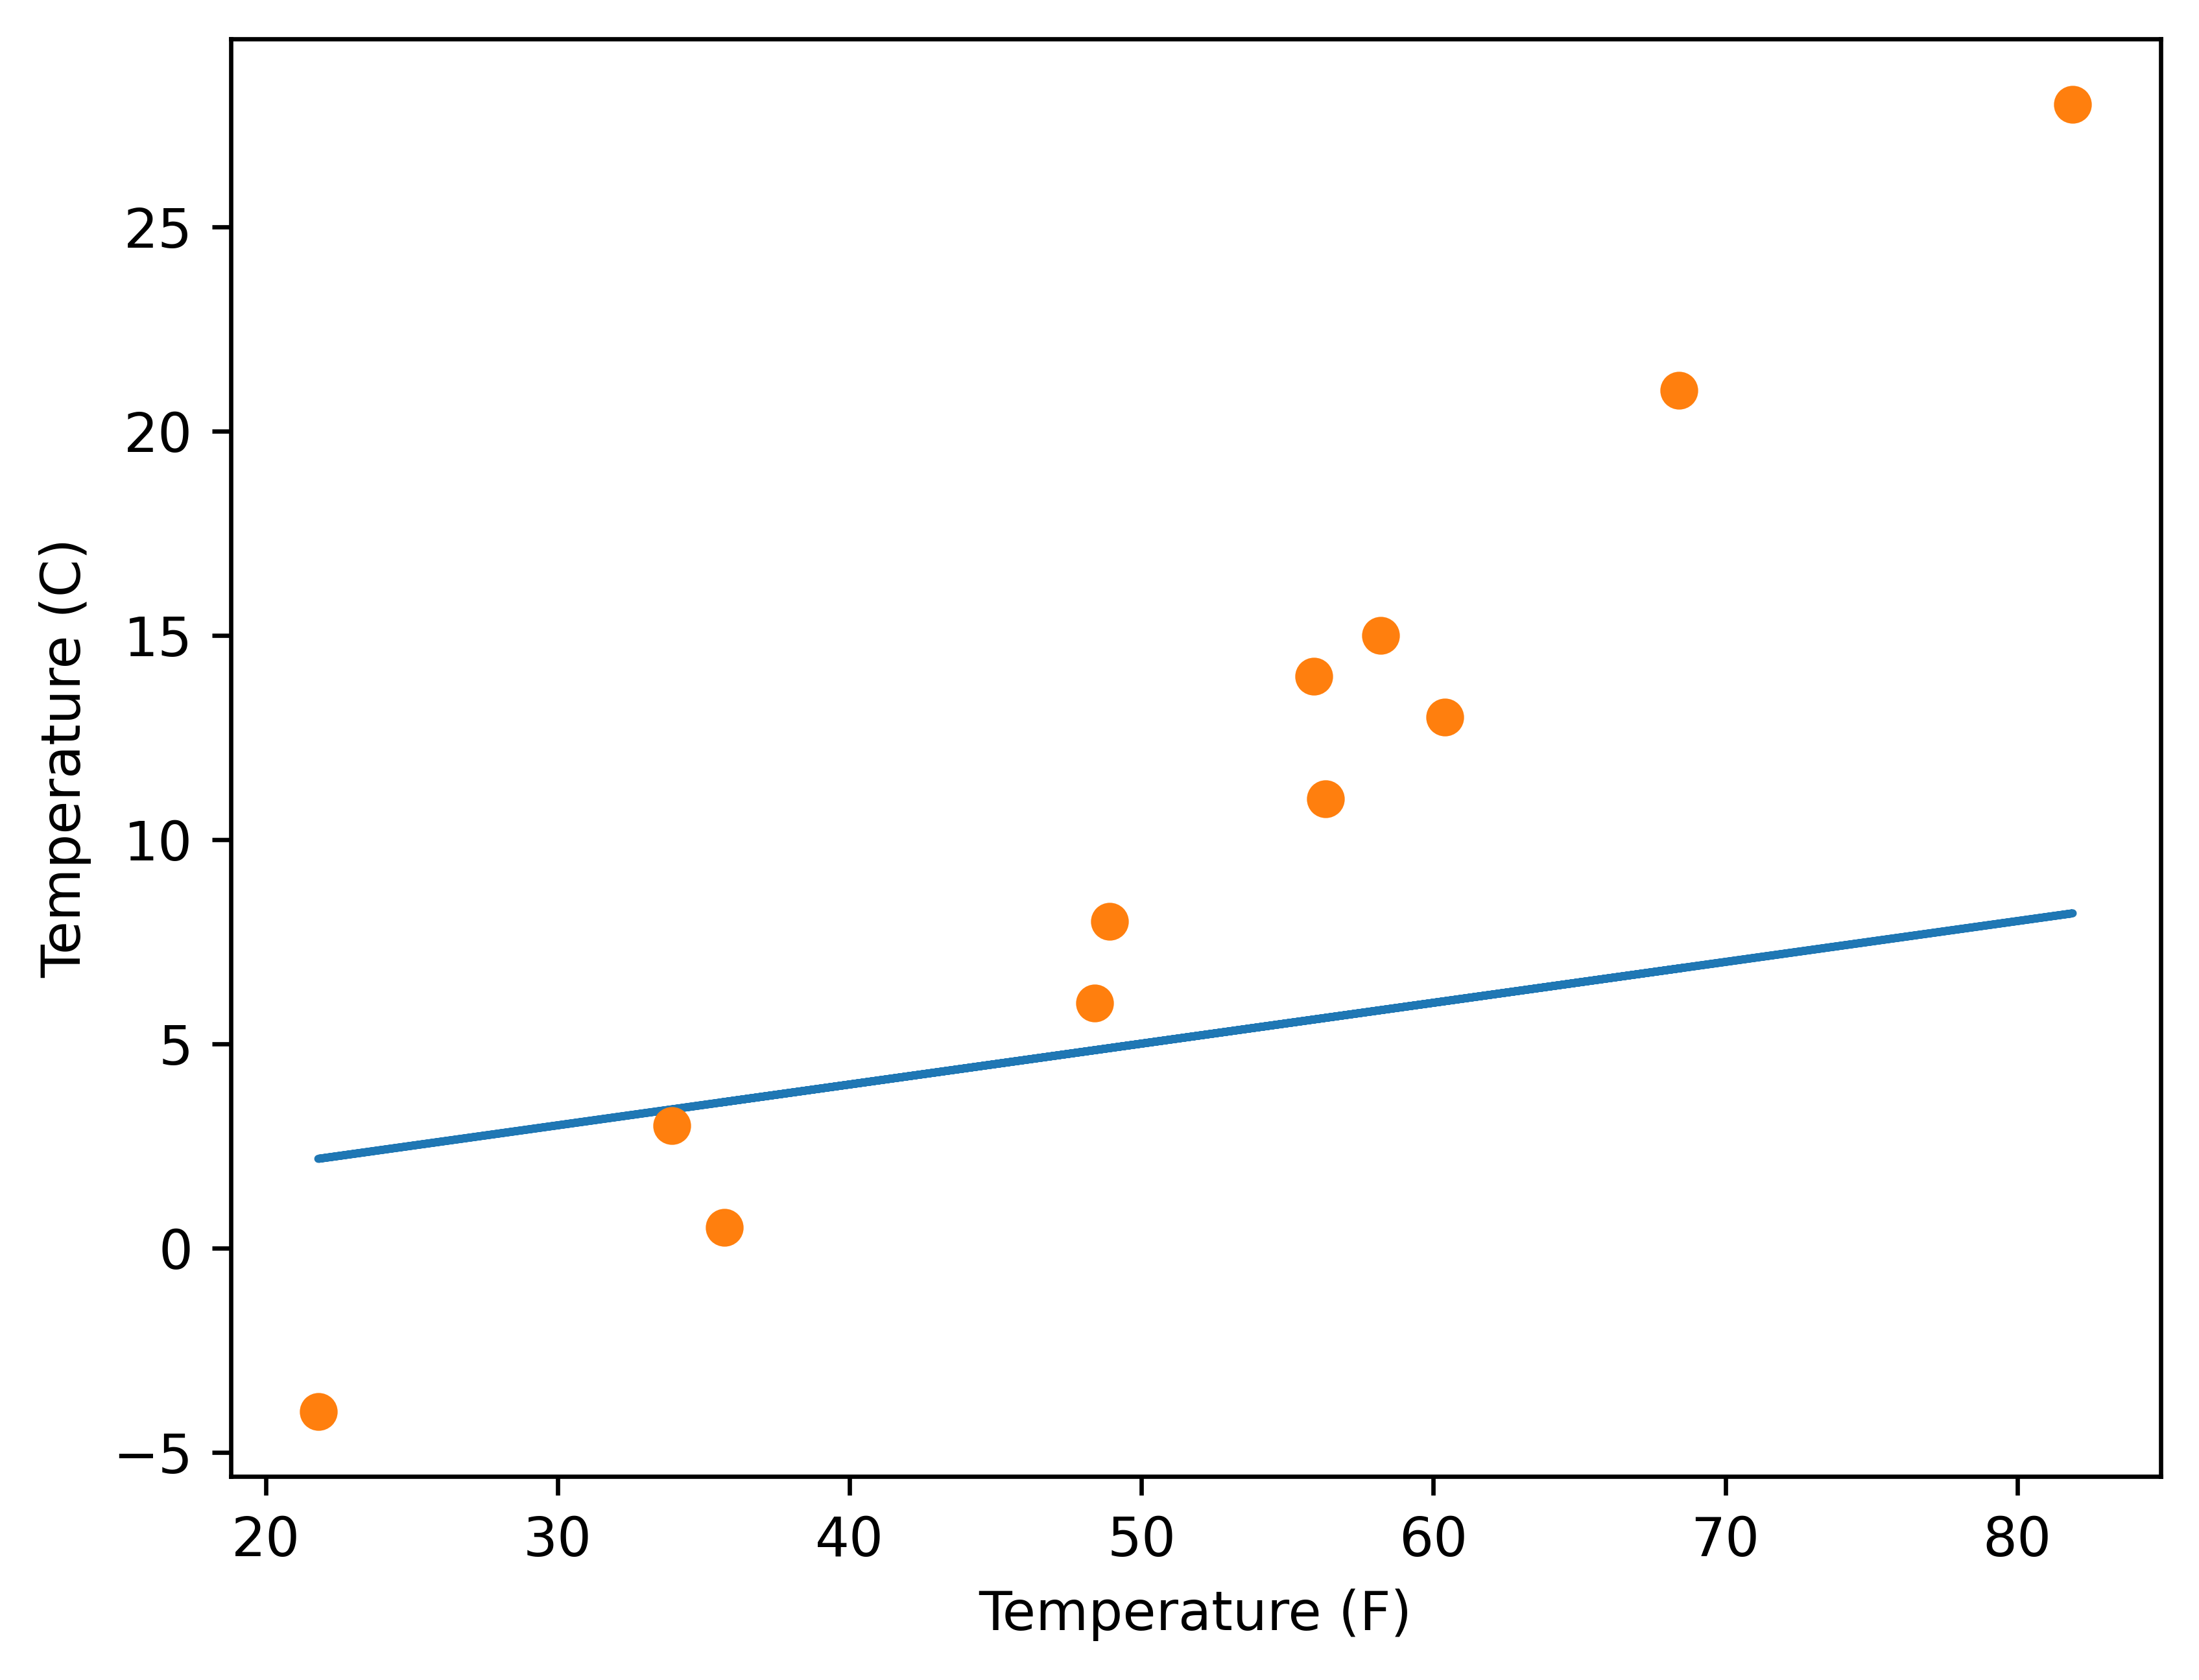

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
params = torch.tensor([1.0, 0.0])
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (F)")
plt.ylabel("Temperature (C)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

파이토치의 자동미분

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [ ]:
params.grad is None

True

In [ ]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

In [ ]:
if params.grad is not None:
    params.grad.zero_()

In [ ]:
def training_loop(n_epochs, lr, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u,*params) # 순방향 전달
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= lr * params.grad

        if epoch % 500 == 0 :
            print("Epoch %d, Loss %f" %(epoch, float(loss)))
    return params

In [ ]:
training_loop(
    n_epochs = 5000,
    lr = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [6]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-5
optimizer = optim.SGD([params], lr = lr)

In [ ]:
optimizer.zero_grad()
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-2
optimizer = optim.SGD([params], lr = lr)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()

optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [ ]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u,*params) # 순방향 전달
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 :
            print("Epoch %d, Loss %f" %(epoch, float(loss)))
    return params

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-2
optimizer = optim.SGD([params], lr = lr)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [10]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([7, 2, 8, 3, 0, 1, 5, 6, 9]), tensor([10,  4]))

In [11]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [8]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <=3 or epoch % 500 == 0 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                f" Validation loss {val_loss.item():.4f}")
    return params

In [11]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-2
optimizer = optim.SGD([params], lr=lr)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

Epoch 1, Training loss 83.4771, Validation loss 66.3570
Epoch 2, Training loss 44.3109, Validation loss 14.4402
Epoch 3, Training loss 37.3050, Validation loss 4.5136
Epoch 500, Training loss 7.1618, Validation loss 2.2583
Epoch 1000, Training loss 3.4705, Validation loss 2.7107
Epoch 1500, Training loss 3.0020, Validation loss 2.9045
Epoch 2000, Training loss 2.9426, Validation loss 2.9777
Epoch 2500, Training loss 2.9350, Validation loss 3.0042
Epoch 3000, Training loss 2.9340, Validation loss 3.0138


tensor([  5.4100, -17.3964], requires_grad=True)

In [13]:
def model2(t_u, w1, w2, b):
    return w2 * t_u**2 + w1*t_u + b

def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model2(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model2(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <=3 or epoch % 500 == 0 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                f" Validation loss {val_loss.item():.4f}")
    return params

In [14]:
import torch
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
lr = 1e-2
optimizer = optim.SGD([params], lr=lr)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

Epoch 1, Training loss 630.6891, Validation loss 878.7678
Epoch 2, Training loss 256041.0312, Validation loss 393155.0000
Epoch 3, Training loss 106487648.0000, Validation loss 162897744.0000
Epoch 500, Training loss nan, Validation loss nan
Epoch 1000, Training loss nan, Validation loss nan
Epoch 1500, Training loss nan, Validation loss nan
Epoch 2000, Training loss nan, Validation loss nan
Epoch 2500, Training loss nan, Validation loss nan
Epoch 3000, Training loss nan, Validation loss nan


tensor([nan, nan, nan], requires_grad=True)